In [1]:
import pandas as pd
import duckdb
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
#from l2therm_in import path, sample_size
#con.commit()
#con.close()
import math

## Old fetch function, no longer in use

In [ ]:
def fetch_data(sample_size: int, con: duckdb.DuckDBPyConnection, E_cutoff: float = 0, ID_cutoff: float = 0):
    '''Samples protein_pairs table, then creates a subset of relevant proteins
and joins to output a sample DataFrame. Leaves behind no database objects.
Relatively fast and less memory intensive than creating a new table.'''
    
    st = time.time()
    
    print('Sampling dataset')
    
    validprot_str = f"""CREATE OR REPLACE TABLE validprot AS
        SELECT
            local_gap_compressed_percent_id,
            scaled_local_query_percent_id,
            scaled_local_symmetric_percent_id,
            bit_score,
            query_align_cov,
            subject_align_cov,
            prot_pair_index,
            meso_protein_int_index,
            thermo_protein_int_index
        FROM protein_pairs
        WHERE local_gap_compressed_percent_id >= {ID_cutoff} AND
              local_E_value <= {E_cutoff}
        USING SAMPLE {sample_size}"""
    
    con.execute(validprot_str)
    
    # Extract protein index values from validprot to Python DataFrame, then to list.
    print('Generating index filter')
    get_idx_str = """SELECT meso_protein_int_index, thermo_protein_int_index FROM validprot"""
    protein_index = con.execute(get_idx_str).df()

    meso_protein_list = [i for i in protein_index['meso_protein_int_index']]
    thermo_protein_list = [i for i in protein_index['thermo_protein_int_index']]

    # Generate single string as comma-separated list of protein indices.
    meso_idx_str = ', '.join(map(str, meso_protein_list))
    thermo_idx_str = ', '.join(map(str, thermo_protein_list))
    
    # Create new tables from proteins containing only proteins mentioned in validprot.
    print('Finding relevant proteins')
    relevant_meso_str = f"""CREATE OR REPLACE TABLE relevant_meso AS 
            SELECT * FROM proteins WHERE protein_int_index IN ({meso_idx_str})"""
    relevant_thermo_str = f"""CREATE OR REPLACE TABLE relevant_thermo AS 
            SELECT * FROM proteins WHERE protein_int_index IN ({thermo_idx_str})"""
    con.execute(relevant_meso_str)
    con.execute(relevant_thermo_str)
    
    # Perform final join of sampled dataset to validprot_df, a DataFrame containing all
    # useful features for downstream processing.
    print('Generating final dataset')
    validprot_df_str = """
        SELECT
            validprot.local_gap_compressed_percent_id AS percent_id,
            proteins_m.protein_seq AS meso_seq,
            proteins_t.protein_seq AS thermo_seq,
            proteins_m.protein_desc AS meso_desc,
            proteins_t.protein_desc AS thermo_desc,
        FROM validprot
        JOIN relevant_meso AS proteins_m ON (validprot.meso_protein_int_index=proteins_m.protein_int_index)
        JOIN relevant_thermo AS proteins_t ON (validprot.thermo_protein_int_index=proteins_t.protein_int_index)
    """
    validprot_df = con.execute(validprot_df_str).df()
    print(f'validprot shape: {validprot_df.shape}')
    
    # Remove new tabled from database and commit changes so that connection will close properly.
    print('Cleaning up...')
    drop_tables = ['validprot', 'relevant_meso', 'relevant_thermo']
    for table in drop_tables:
        drop_str = f"""DROP TABLE {table}"""
        con.execute(drop_str)
    con.commit()
    print('Done.')
    
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')

    return validprot_df, elapsed_time

# def build_validprot_table(params):

### Functions from c1_preprocessing.py DO NOT ALTER

In [2]:
def connect_db(path: str):
    '''Runs duckdb.connect() function on database path with timing. Returns a 
duckdb.DuckDBPyConnection object'''
    
    st = time.time()

    print('Connecting to database...')
    con = duckdb.connect(path)

    et = time.time()
    elapsed_time = et - st
    print(f'Connection established! Execution time: {elapsed_time} seconds')
    return con
        
def fetch_data(sample_size: int, con: duckdb.DuckDBPyConnection, E_cutoff: float = 0, ID_cutoff: float = 0):
    '''Samples protein_pairs table, then creates a subset of relevant proteins
and joins to output a sample DataFrame. Leaves behind no database objects.
Relatively fast and less memory intensive than creating a new table.'''
    
    st = time.time()
    
    print('Sampling dataset')
    
    validprot_str = f"""CREATE OR REPLACE TABLE validprot AS
        SELECT
            local_gap_compressed_percent_id,
            local_E_value,
            prot_pair_index,
            meso_protein_int_index,
            thermo_protein_int_index
        FROM protein_pairs
        WHERE local_gap_compressed_percent_id >= {ID_cutoff} AND
              local_E_value <= {E_cutoff}
        USING SAMPLE {sample_size}"""
    
    con.execute(validprot_str)
    
    # Extract protein index values from validprot to Python DataFrame, then to list.
    print('Generating index filter')
    get_idx_str = """SELECT meso_protein_int_index, thermo_protein_int_index FROM validprot"""
    protein_index = con.execute(get_idx_str).df()

    meso_protein_list = [i for i in protein_index['meso_protein_int_index']]
    thermo_protein_list = [i for i in protein_index['thermo_protein_int_index']]
    print(protein_index)
    # Generate single string as comma-separated list of protein indices.
    meso_idx_str = ', '.join(map(str, meso_protein_list))
    thermo_idx_str = ', '.join(map(str, thermo_protein_list))
    
    # Create new tables from proteins containing only proteins mentioned in validprot.
    print('Finding relevant proteins')
    relevant_meso_str = f"""CREATE OR REPLACE TABLE relevant_meso AS 
            SELECT * FROM proteins WHERE protein_int_index IN ({meso_idx_str})"""
    relevant_thermo_str = f"""CREATE OR REPLACE TABLE relevant_thermo AS 
            SELECT * FROM proteins WHERE protein_int_index IN ({thermo_idx_str})"""
    con.execute(relevant_meso_str)
    con.execute(relevant_thermo_str)
    
    # Perform final join of sampled dataset to validprot_df, a DataFrame containing all
    # useful features for downstream processing.
    print('Generating final dataset')
    validprot_df_str = """
        SELECT
            validprot.local_gap_compressed_percent_id AS percent_id,
            proteins_m.protein_seq AS meso_seq,
            proteins_t.protein_seq AS thermo_seq,
            proteins_m.protein_desc AS meso_desc,
            proteins_t.protein_desc AS thermo_desc,
        FROM validprot
        JOIN relevant_meso AS proteins_m ON (validprot.meso_protein_int_index=proteins_m.protein_int_index)
        JOIN relevant_thermo AS proteins_t ON (validprot.thermo_protein_int_index=proteins_t.protein_int_index)
    """
    validprot_df = con.execute(validprot_df_str).df()
    print(f'validprot shape: {validprot_df.shape}')
    
    # Remove new tabled from database and commit changes so that connection will close properly.
    print('Cleaning up...')
    drop_tables = ['validprot', 'relevant_meso', 'relevant_thermo']
    for table in drop_tables:
        drop_str = f"""DROP TABLE {table}"""
        con.execute(drop_str)
    con.commit()
    print('Done.')
    
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')

    return validprot_df, elapsed_time

# def build_validprot_table(params):


In [3]:
con = connect_db('/mnt/c/Users/Ryan/Documents/database')

Connecting to database...
Connection established! Execution time: 17.364574670791626 seconds


### Understanding taxa tables

Trying to get a grasp on what these tables represent. Luckily they are small enough to just pull the whole thing into python. It appears the taxa table contains 16S data for organisms represented in the dataset while the taxa_pairs table contains blast results similar to protein_pairs for 16S. The is_pair column is the thresholds these data to define meso/thermo taxa 'analogues'. The protein sequences from these are then combinatorially scanned for >50% coverage. This protein data makes up proteins and protein_pairs.

In [4]:
taxa = con.execute("""SELECT * FROM taxa""").df()
taxa_pairs = con.execute("""SELECT * FROM taxa_pairs""").df()

In [5]:
false_pairs = list(taxa_pairs[taxa_pairs['is_pair'] == False]['taxa_pair_index'])

In [7]:
taxa[taxa['taxa_index'] == 16361]

taxa_index  ncbi_taxid  record_name  \
16361       16361      348826  NZ_CP045488   

                                                filepath  \
16361  ./data/refseq/archaea/GCF_009392895.1_ASM93928...   

                                                taxonomy  \
16361  Archaea Euryarchaeota Stenosarchaea group Halo...   

                     organism  bacdive_id ogt_scraped_string  \
16361  Natronorubrum aibiense    134191.0                 45   

                                             seq_16srRNA  len_16s   ogt  \
16361  ATTCCGGTTGATCCTGCCGGAGGTCATTGCTATTGGAGTCCGATTT...   1471.0  45.0   

      thermophile_label  
16361              True

In [8]:
taxa[taxa['taxa_index'] == 16481]

taxa_index  ncbi_taxid  record_name  \
16481       16481      588898  NZ_CP019327   

                                                filepath  \
16481  ./data/refseq/archaea/GCF_001971705.1_ASM19717...   

                                                taxonomy  \
16481  Archaea Euryarchaeota Stenosarchaea group Halo...   

                        organism  bacdive_id ogt_scraped_string  \
16481  Haloterrigena daqingensis    133550.0                 35   

                                             seq_16srRNA  len_16s   ogt  \
16481  ATTCCGGTTGATCCTGCCGGAGGTCATTGCTATTGGAGTCCGATTT...   1474.0  35.0   

      thermophile_label  
16481             False

<Axes: xlabel='len_16s', ylabel='Count'>

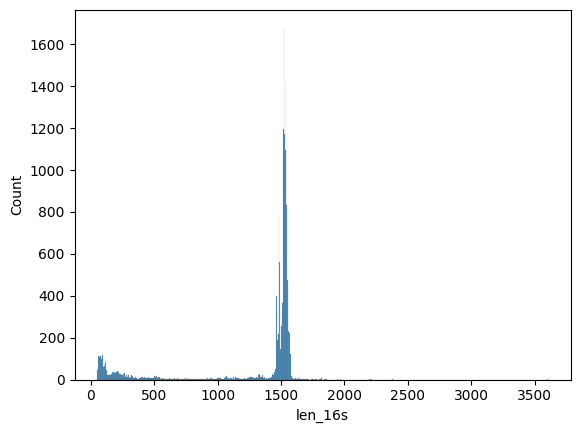

In [9]:
sns.histplot(data=taxa, x='len_16s')

This is interesting... can 16S be this short? Let's ust check relevant taxa (i.e. those included in a taxa pair).

In [10]:
relevant_taxa = np.append(np.unique(taxa_pairs['meso_index']), np.unique(taxa_pairs['thermo_index']))

In [11]:
taxa_filt = taxa[taxa['taxa_index'].isin(relevant_taxa)]
taxa_filt.shape

(4347, 12)

<Axes: xlabel='len_16s', ylabel='Count'>

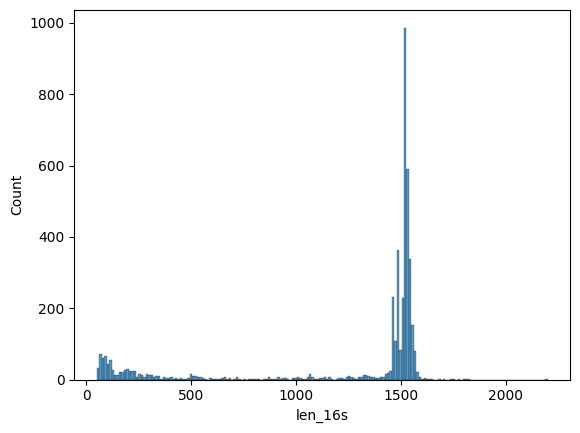

In [12]:
sns.histplot(data=taxa_filt, x='len_16s')

Still a bunch of short ones. Let's see what they are.

In [13]:
cutoff = 1000
short = taxa_filt[taxa_filt['len_16s'] < cutoff]
long = taxa_filt[taxa_filt['len_16s'] >= cutoff]
print(f'{short.shape[0]*100/taxa_filt.shape[0]}% of taxa have 16s sequence less than {cutoff} bp')
short.head()

19.85277202668507% of taxa have 16s sequence less than 1000 bp


taxa_index  ncbi_taxid         record_name  \
36          36     1091037     NZ_BNAO01000001   
49          49     1121338     NZ_LTBA01000001   
67          67      254793  NZ_JAKILG010000001   
71          71     1159017     NZ_FMXN01000031   
75          75     1776856     NZ_BMDG01000001   

                                             filepath  \
36  ./data/refseq/bacteria/GCF_014653435.1_ASM1465...   
49  ./data/refseq/bacteria/GCF_001594005.1_ASM1594...   
67  ./data/refseq/bacteria/GCF_023283765.1_ASM2328...   
71  ./data/refseq/bacteria/GCF_900104245.1_IMG-tax...   
75  ./data/refseq/bacteria/GCF_014635665.1_ASM1463...   

                                             taxonomy  \
36  Bacteria Proteobacteria Gammaproteobacteria Al...   
49  Bacteria Firmicutes Clostridia Eubacteriales C...   
67  Bacteria Proteobacteria Gammaproteobacteria Al...   
71  Bacteria Proteobacteria Gammaproteobacteria Al...   
75  Bacteria Actinobacteria Micrococcales Promicro...   

                                organism  bacdive_id ogt_scraped_string  \
36             Alishewanella longhuensis    133764.0                 30   
49  Clostridium tepidiprofundi DSM 19306      2845.0                 50   
67                   Shewanella profunda     14072.0               27.5   
71                Pseudidiomarina indica    133925.0                 36   
75                  Isoptericola cucumis    132577.0                 28   

                                          seq_16srRNA  len_16s   ogt  \
36  TAAGACAGGTGCTGCATGGCTGTCGTCAGCTCGTGTTGTGAAATGT...    504.0  30.0   
49  GGAGCCAGCGGCCGAAGGTGGGGTTGGTGATTGGGGTGAAGTCGTA...     89.0  50.0   
67  ACCTTCGGGGGGGCGCTCACCACTTTGTGGTTCATGACTGGGGTGA...     96.0  27.5   
71  AAATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGG...     92.0  36.0   
75  GGTGGAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGG...    857.0  28.0   

   thermophile_label  
36             False  
49              True  
67             False  
71             False  
75             False

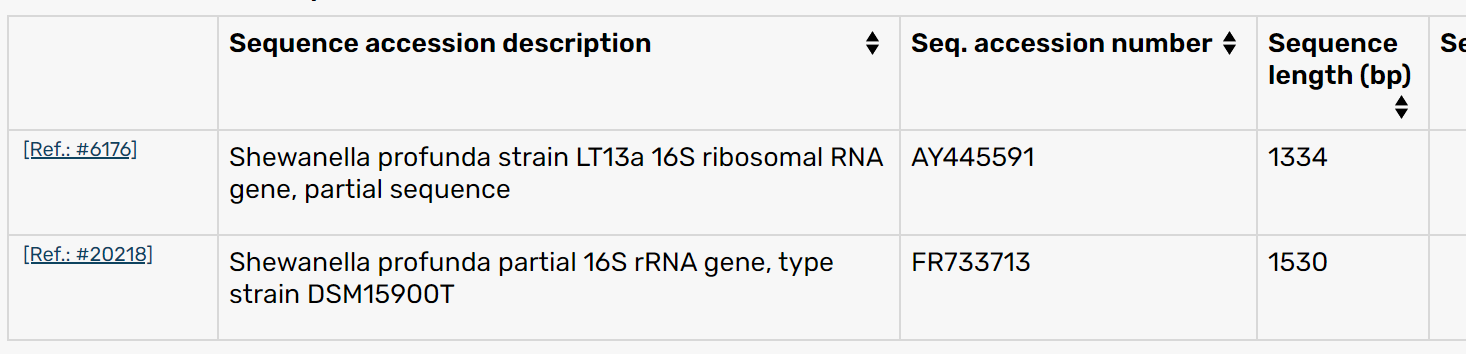

Ok so something is clearly up with these 16S sequence lengths. Probaby they are partial sequences. We should be really careful using these for ML. Is it possible that our taxa pairs are also thrown off by this?

#### Checking to see if the short reads have less pairs

In [14]:
def num_pairs(trunc_df, main_pair_df):
    
    num_pairs = []
    
    for index in trunc_df['taxa_index']:
        m_count = main_pair_df[main_pair_df['meso_index'] == index].value_counts()
        t_count = main_pair_df[main_pair_df['thermo_index'] == index].value_counts()
        total = m_count + t_count
        print(total)
        num_pairs.append(total)
        
    return num_pairs      

In [143]:
taxa_filt[taxa_filt['meso_index'] == 49].value_counts()

KeyError: 'meso_index'

In [140]:
num_pairs(short, taxa_pairs)

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            36          0.828000                         0.265385                       0.401163                           4.873940e-111  1062               1559             503                4                    498              0.319231         500                0.992063           214.0      8182             False     NaN
10952         36          0.819444                         0.277740                       0.414867                           9.683710e-113  990                1486             503                5                    497              0.334230         499                0.990079           217.0      492273           False     NaN
10280         36

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
24            299         0.906250                         0.037275                       0.062771                           6.412830e-17   6                  69               69                 6                    64               0.041131         64                 0.219178           46.0       3360             False     NaN
8765          299         0.919355                         0.267606                       0.225743                           2.224550e-18   4                  65               65                 4                    62               0.291080         62                 0.212329           47.0       387102           False     NaN
14721         29

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
24            801         0.805442                         0.380463                       0.489661                           6.240720e-138  703                1438             724                3                    736              0.473008         722                0.837587           262.0      2987             False     NaN
9827          801         0.831019                         0.458493                       0.591433                           0.000000e+00   710                1566             862                1                    857              0.547254         862                1.000000           389.0      446705           False     NaN
10208         80

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            1182        0.913793                         0.033974                       0.065392                           3.082480e-15   1503               1560             61                 4                    58               0.037179         58                 0.950820           43.0       8540             False     NaN
9380          1182        0.931034                         0.034549                       0.066502                           6.442090e-17   1506               1563             61                 4                    58               0.037108         58                 0.950820           46.0       433351           False     NaN
11783         11

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
1844          5           0.969231                         0.913043                       0.079445                           1.091760e-25   5                  69               69                 5                    65               0.942029         65                 0.042848           59.0       67135            False     NaN
              10459       0.966667                         0.840580                       0.072682                           6.907580e-23   5                  64               64                 5                    60               0.869565         60                 0.039293           54.0       67749            False     NaN
              10

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            2285        0.968254                         0.039103                       0.074164                           4.421220e-23   7                  69               69                 7                    63               0.040385         63                 0.741176           57.0       8443             False     NaN
9827          2285        0.950000                         0.036398                       0.069049                           1.020170e-19   6                  65               65                 6                    60               0.038314         60                 0.705882           51.0       447475           False     NaN
11569         22

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            2802        0.968254                         0.039103                       0.074074                           4.421220e-23   7                  69               69                 7                    63               0.040385         63                 0.724138           57.0       8441             False     NaN
9827          2802        0.950000                         0.036398                       0.068966                           1.020170e-19   6                  65               65                 6                    60               0.038314         60                 0.689655           51.0       447474           False     NaN
11569         28

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            3146        0.837209                         0.092308                       0.164477                           3.040210e-29   7                  190              172                7                    184              0.117949         166                0.869110           68.0       8319             False     NaN
9791          3146        0.815029                         0.207965                       0.324511                           3.569530e-30   4                  180              172                4                    177              0.261062         169                0.884817           69.0       440004           False     NaN
11401         31

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
24            3494        0.901639                         0.035347                       0.052306                           3.074460e-15   6                  66               66                 6                    61               0.039203         61                 0.111517           43.0       3385             False     NaN
12835         3494        0.808050                         0.167522                       0.247981                           8.959070e-53   239                566              546                224                  328              0.210526         323                0.590494           110.0      576572           False     NaN
9380          34

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
614           3748        0.950000                         0.640449                       0.686747                           4.636330e-21   6                  65               65                 6                    60               0.674157         60                 0.779221           51.0       28121            False     NaN
12704         3748        0.932203                         0.495495                       0.585106                           1.061260e-18   7                  65               65                 7                    59               0.531532         59                 0.766234           47.0       562819           False     NaN
8765          37

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            4400        0.983333                         0.037821                       0.071776                           4.421220e-23   6                  65               65                 6                    60               0.038462         60                 0.714286           57.0       8438             False     NaN
9822          4400        0.984615                         0.335079                       0.465455                           7.781860e-27   4                  68               68                 4                    65               0.340314         65                 0.773810           62.0       448113           False     NaN
11569         44

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
4841          5           0.984615                         0.385542                       0.076055                           6.644160e-27   5                  69               69                 5                    65               0.391566         65                 0.042848           62.0       222119           False     NaN
              10713       0.984375                         0.379518                       0.074777                           2.413680e-26   6                  69               69                 6                    64               0.385542         64                 0.042133           61.0       222156           False     NaN
              10

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            5268        0.923077                         0.038462                       0.073710                           3.691650e-19   1496               1560             68                 4                    65               0.041667         65                 0.955882           50.0       8520             False     NaN
9301          5268        1.000000                         0.141921                       0.247148                           4.144750e-28   394                458              68                 4                    65               0.141921         65                 0.955882           65.0       426341           False     NaN
11544         52

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            5782        0.882812                         0.072436                       0.129662                           2.538530e-25   7                  147              131                7                    141              0.090385         125                0.683060           61.0       8364             False     NaN
9804          5782        0.848837                         0.093710                       0.167720                           2.500460e-39   6                  180              174                6                    175              0.112323         169                0.923497           86.0       443600           False     NaN
11569         57

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
1462          6211        0.951613                         0.039811                       0.070155                           7.309670e-21   8                  69               69                 8                    62               0.041835         62                 0.310              53.0       55895            False     NaN
3606          6211        0.807692                         0.098592                       0.173862                           5.572970e-22   1                  180              196                1                    180              0.120724         196                0.980              55.0       163276           False     NaN
6626          62

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            6595        0.917647                         0.050000                       0.094317                           9.221930e-25   7                  93               89                 7                    87               0.055769         83                 0.882979           60.0       8372             False     NaN
9827          6595        0.970588                         0.042146                       0.079518                           7.015090e-26   1                  68               68                 1                    68               0.043423         68                 0.723404           62.0       447360           False     NaN
11657         65

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
1462          6955        0.967742                         0.040486                       0.068532                           1.524680e-22   8                  69               69                 8                    62               0.041835         62                 0.230483           56.0       55855            False     NaN
2426          6955        0.889734                         0.151456                       0.257993                           9.391590e-90   5                  267              267                5                    263              0.170227         263                0.977695           176.0      116701           False     NaN
3606          69

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
24            7446        0.828000                         0.266067                       0.393723                           1.319810e-125  511                1009             525                27                   499              0.320694         499                0.912249           240.0      3134             False     NaN
11402         7446        0.865900                         0.347692                       0.489442                           2.671930e-159  241                758              528                9                    518              0.398462         520                0.950640           300.0      505871           False     NaN
10482         74

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            7872        0.764574                         0.218590                       0.340830                           1.304570e-46   359                823              441                1                    465              0.298077         441                1.0                99.0       8252             False     NaN
11814         7872        0.783964                         0.224777                       0.350772                           1.704670e-59   360                824              441                1                    465              0.296935         441                1.0                122.0      529057           False     NaN
11707         78

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
24            8218        0.830508                         0.094473                       0.148260                           6.874070e-40   255                431              408                232                  177              0.113753         177                0.414520           87.0       3280             False     NaN
8088          8218        0.776978                         0.211075                       0.330275                           2.909320e-57   7                  424              422                7                    418              0.272313         416                0.974239           118.0      352353           False     NaN
8686          82

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
24            8661        0.752747                         0.264139                       0.389573                           4.792620e-32   6                  572              548                6                    567              0.364396         543                0.980144           73.0       3288             False     NaN
12320         8661        0.796262                         0.275016                       0.405136                           3.821860e-70   8                  556              541                8                    549              0.354422         534                0.963899           141.0      539019           False     NaN
11852         86

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
9046          31          0.968750                         0.534483                       0.075841                           7.694290e-25   7                  70               70                 7                    64               0.551724         64                 0.042133           58.0       409183           False     NaN
              10456       0.983051                         0.500000                       0.070775                           1.015430e-23   7                  65               65                 7                    59               0.508621         59                 0.038739           56.0       409227           False     NaN
              10

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
24            9464        0.811151                         0.289846                       0.397883                           3.075730e-108  261                834              657                110                  574              0.368895         548                0.770745           209.0      3193             False     NaN
11402         9464        0.828070                         0.363077                       0.469418                           7.457310e-146  13                 582              657                88                   570              0.438462         570                0.801688           276.0      505884           False     NaN
10575         94

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
9791          5           0.842105                         0.755162                       0.466515                           1.688550e-135  4                  638              601                4                    635              0.936578         598                0.394199           257.0      438024           False     NaN
              10826       0.966667                         0.085546                       0.147583                           9.040840e-22   6                  65               65                 6                    60               0.088496         60                 0.555556           54.0       440107           False     NaN
              10

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            9986        0.817680                         0.094872                       0.166667                           1.002270e-33   7                  190              184                7                    184              0.117949         178                0.824074           76.0       8286             False     NaN
9822          9986        0.952381                         0.314136                       0.294840                           2.360490e-22   3                  65               65                 3                    63               0.329843         63                 0.291667           54.0       448537           False     NaN
11569         99

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            10425       0.878049                         0.046154                       0.087698                           2.797310e-20   1479               1560             82                 1                    82               0.052564         82                 1.000000           52.0       8517             False     NaN
9380          10425       0.933333                         0.035829                       0.068085                           4.881430e-18   1504               1563             82                 23                   60               0.038388         60                 0.731707           48.0       433338           False     NaN
11783         10

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
1462          10925       0.951613                         0.039811                       0.068805                           7.309670e-21   8                  69               69                 8                    62               0.041835         62                 0.266094           53.0       55889            False     NaN
3606          10925       0.950820                         0.038900                       0.067285                           2.671820e-20   8                  68               68                 8                    61               0.040912         61                 0.261803           52.0       163316           False     NaN
6626          10

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            11346       0.837209                         0.092308                       0.165612                           3.040210e-29   7                  190              172                7                    184              0.117949         166                0.927374           68.0       8313             False     NaN
9791          11346       0.815029                         0.207965                       0.329055                           3.569530e-30   4                  180              172                4                    177              0.261062         169                0.944134           69.0       439999           False     NaN
11401         11

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
1462          11691       0.951613                         0.039811                       0.074684                           7.309670e-21   8                  69               69                 8                    62               0.041835         62                 0.632653           53.0       55888            False     NaN
3606          11691       0.950820                         0.038900                       0.073002                           2.671820e-20   8                  68               68                 8                    61               0.040912         61                 0.622449           52.0       163314           False     NaN
6626          11

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
4508          12215       0.872000                         0.073302                       0.133333                           7.334700e-21   8                  130              148                8                    123              0.082717         141                0.952703           53.0       213284           False     NaN
7470          12215       0.916667                         0.085826                       0.156584                           2.032400e-49   2                  143              147                2                    142              0.092328         146                0.986486           104.0      322154           False     NaN
10952         12

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
24            12561       0.792157                         0.129820                       0.219924                           3.631560e-33   342                601              259                1                    260              0.167095         259                0.921708           75.0       3287             False     NaN
11324         12561       0.861538                         0.152277                       0.255708                           2.528490e-62   300                555              281                1                    256              0.174031         281                1.000000           127.0      502437           False     NaN
12416         12

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            12959       0.890411                         0.041667                       0.079608                           1.341100e-18   1488               1560             73                 1                    73               0.046795         73                 1.000000           49.0       8524             False     NaN
9301          12959       0.972603                         0.155022                       0.267420                           3.140640e-29   386                458              73                 1                    73               0.159389         73                 1.000000           67.0       426336           False     NaN
11544         12

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
24            13503       0.906250                         0.037275                       0.065537                           6.412830e-17   6                  69               69                 6                    64               0.041131         64                 0.299065           46.0       3346             False     NaN
8197          13503       0.800000                         0.091630                       0.154188                           3.525650e-18   7                  133              137                7                    127              0.111894         131                0.612150           48.0       356146           False     NaN
8765          13

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
24            13969       0.915254                         0.034704                       0.064555                           8.463090e-16   8                  66               66                 8                    59               0.037918         59                 0.504274           44.0       3370             False     NaN
268           13969       0.831776                         0.059294                       0.110012                           2.246120e-16   8                  115              115                8                    108              0.071952         108                0.923077           45.0       19276            False     NaN
14721         13

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
24            14555       0.808795                         0.271851                       0.382459                           8.584320e-95   261                802              656                141                  542              0.348329         516                0.786585           185.0      3211             False     NaN
11783         14555       0.822878                         0.338135                       0.451646                           6.407190e-128  27                 566              656                119                  540              0.409401         538                0.820122           244.0      525503           False     NaN
11657         14

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
1462          14931       0.951613                         0.039811                       0.070490                           7.309670e-21   8                  69               69                 8                    62               0.041835         62                 0.322917           53.0       55884            False     NaN
3606          14931       0.815642                         0.097921                       0.173500                           1.162430e-23   1                  173              189                1                    173              0.116030         189                0.984375           58.0       163263           False     NaN
6626          14

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            15256       0.781931                         0.160897                       0.266313                           4.739220e-46   4                  320              325                4                    317              0.203205         322                0.990769           98.0       8253             False     NaN
9887          15256       0.811075                         0.790476                       0.778125                           1.085850e-50   6                  303              325                6                    298              0.946032         320                0.984615           105.0      449107           False     NaN
11707         15

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
37            15813       0.953125                         0.039103                       0.069240                           5.834740e-22   6                  69               69                 6                    64               0.041026         64                 0.316832           55.0       8487             False     NaN
9804          15813       0.817143                         0.091784                       0.162500                           3.345780e-24   7                  175              189                7                    169              0.108472         183                0.905941           59.0       443730           False     NaN
11401         15

thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
16445         1927        0.793814                         0.498382                       0.169604                           2.280810e-24   98                 296              941                751                  199              0.644013         191                0.126742           58.0       743454           False     NaN
              3038        0.776650                         0.495146                       0.168967                           1.093470e-22   98                 296              937                747                  199              0.644013         191                0.127164           55.0       743459           False     NaN
              16

[thermo_index  meso_index  local_gap_compressed_percent_id  scaled_local_query_percent_id  scaled_local_symmetric_percent_id  local_E_value  query_align_start  query_align_end  subject_align_end  subject_align_start  query_align_len  query_align_cov  subject_align_len  subject_align_cov  bit_score  taxa_pair_index  is_pair
 37            36          0.828000                         0.265385                       0.401163                           4.873940e-111  1062               1559             503                4                    498              0.319231         500                0.992063           214.0      8182             False     NaN
 10952         36          0.819444                         0.277740                       0.414867                           9.683710e-113  990                1486             503                5                    497              0.334230         499                0.990079           217.0      492273           False     NaN
 10280       

#### List of column names in protein_pairs and proteins tables

In [15]:
for t in ['protein_pairs', 'proteins']:
    cmd = f"""SELECT * FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{t}'"""
    print(f' Columns in {t} are:\n{con.execute(cmd).df()["column_name"]}')
    print('\n')

 Columns in protein_pairs are:
0                  thermo_protein_index
1                    meso_protein_index
2       local_gap_compressed_percent_id
3         scaled_local_query_percent_id
4     scaled_local_symmetric_percent_id
5                         local_E_value
6                     query_align_start
7                       query_align_end
8                     subject_align_end
9                   subject_align_start
10                      query_align_len
11                      query_align_cov
12                    subject_align_len
13                    subject_align_cov
14                            bit_score
15                         thermo_index
16                           meso_index
17                      prot_pair_index
18               meso_protein_int_index
19             thermo_protein_int_index
20                      taxa_pair_index
Name: column_name, dtype: object


 Columns in proteins are:
0           taxa_index
1        protein_index
2          protein_seq

### Test dataset with sample of 10000

In [16]:
test_df = con.execute("""SELECT * FROM protein_pairs USING SAMPLE 10000""").df()
protein_df = con.execute("""SELECT * FROM proteins USING SAMPLE 10000""").df()

### Histograms of potential features

1. E-value: Probably not a good metric given many are just 0. Could be due to 32-bit encoding during database generation.
2. bit score: Better metric as all entries have a value.
3. ID scores: All look fairly similar and correlated. Need to test that in next cell. May as well keep all for now, but likely will not need to do much special sampling for each individual one.
4. Query coverage: Fairly flat, some more values at the high end. Sampling should be more or less representative without binning. Threshold at 0.5 during database generation.
5. Subject coverage: No apparent threshold with some low values.

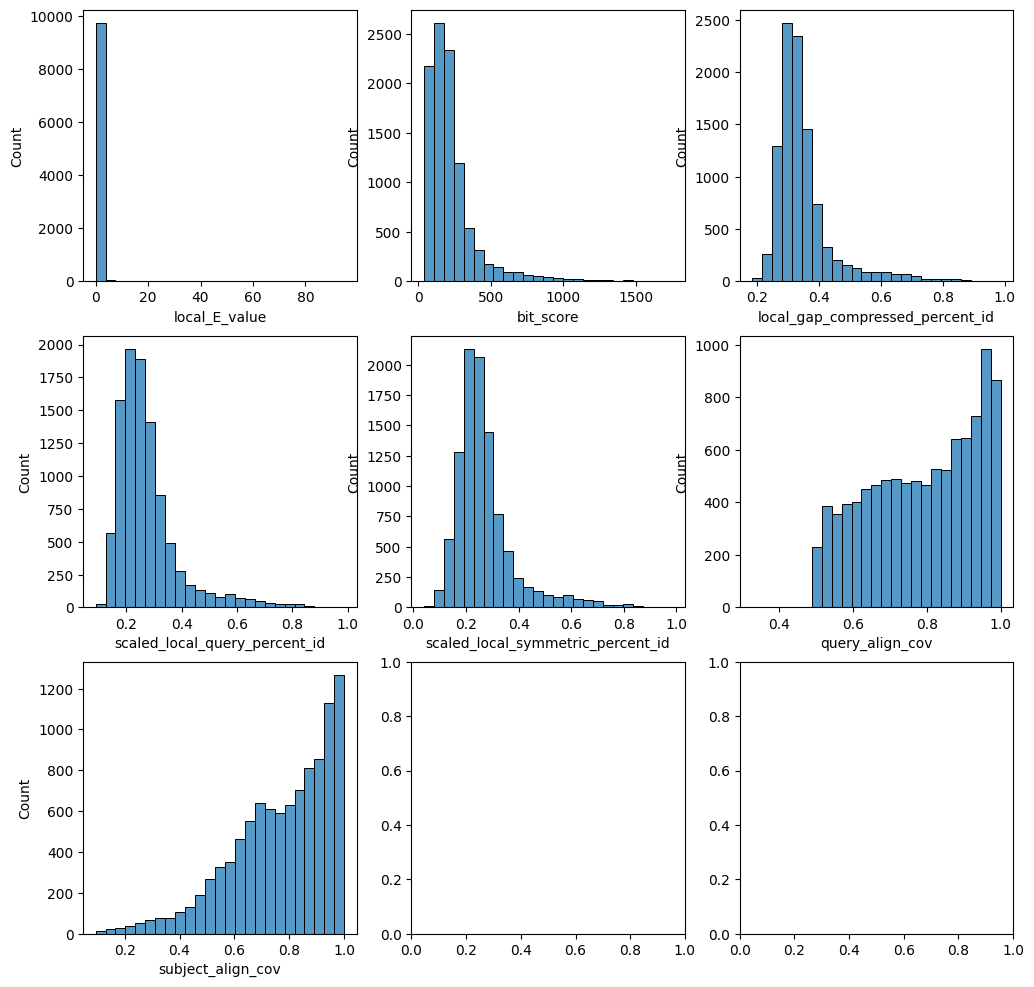

In [17]:
attributes = ['local_E_value', 'bit_score', 'local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 
              'scaled_local_symmetric_percent_id', 'query_align_cov','subject_align_cov']

clean_df = test_df[attributes]

cols = 3
rows = math.ceil(len(attributes)/3)

fig, ax = plt.subplots(rows, cols, figsize = (4*cols,4*rows))

order = [[i,j] for i in range(rows) for j in range(cols)]

for i, attribute in enumerate(attributes):
    sns.histplot(ax = ax[order[i][0], order[i][1]], x = clean_df[attribute], bins = 25)

Correlation between ID values is pretty close to parity. Some outliers.

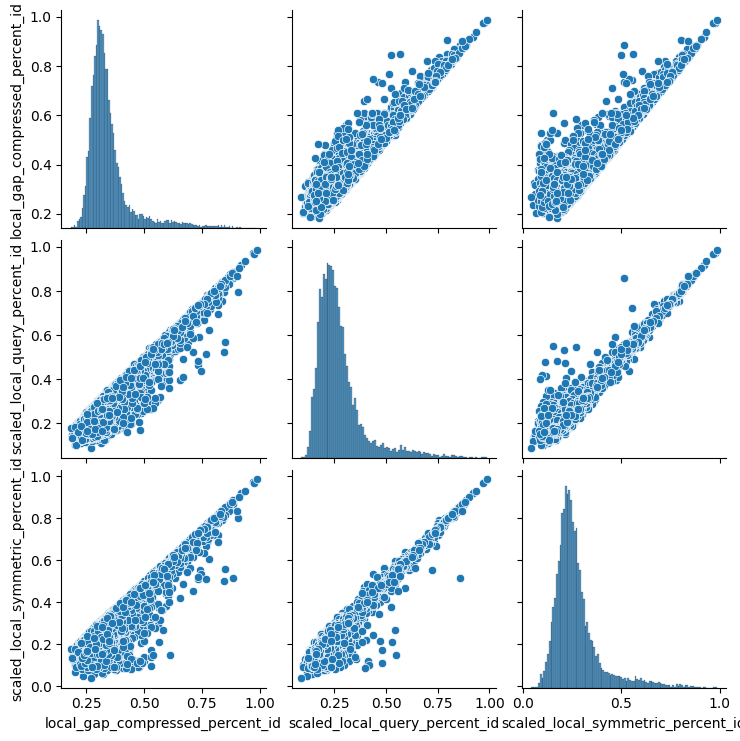

In [18]:
sns.pairplot(clean_df[['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 
              'scaled_local_symmetric_percent_id']])

In [19]:
# Reports statistics on a given feature in the duckdb database.
def stats_num(table_name, feature_list):
    for i in feature_list:
        command = f"""SELECT {i} FROM {table_name}"""
        df = con.execute(command).df()
        print(f'Describe {i} from {table_name}')
        print(df.describe()) 
        print('\n')
    return

### Stats on protein_pairs attributes

In [20]:
stats_num('protein_pairs', attributes)

Describe local_E_value from protein_pairs
       local_E_value
count   1.815005e+08
mean    5.723365e-01
std     4.714770e+00
min     0.000000e+00
25%     4.750000e-28
50%     9.430000e-17
75%     3.990000e-08
max     1.000000e+02


Describe bit_score from protein_pairs
          bit_score
count  1.815005e+08
mean   2.255338e+02
std    1.850755e+02
min    3.000000e+01
25%    1.140000e+02
50%    1.810000e+02
75%    2.610000e+02
max    2.137000e+03


Describe local_gap_compressed_percent_id from protein_pairs
       local_gap_compressed_percent_id
count                     1.815005e+08
mean                      3.474267e-01
std                       1.777498e-01
min                       8.411215e-02
25%                       2.928571e-01
50%                       3.238636e-01
75%                       3.650794e-01
max                       1.000000e+00


Describe scaled_local_query_percent_id from protein_pairs
       scaled_local_query_percent_id
count                   1.815005e+08
me

### How many proteins have annotations?

We may want to figure out a way to parse which descriptions are useful (e.g. 'phophoserine transferase' and which are not,
e.g. 'Tim44 domain-containing protein'

In [56]:
print(f'{protein_df["protein_desc"].value_counts()["hypothetical protein"]/100}% of proteins are unannotated')
protein_df["protein_desc"].value_counts()

15.97% of proteins are unannotated


hypothetical protein                                                                    1597
ABC transporter permease                                                                  89
ABC transporter ATP-binding protein                                                       85
MFS transporter                                                                           73
GNAT family N-acetyltransferase                                                           63
                                                                                        ... 
Tim44 domain-containing protein                                                            1
bifunctional proline dehydrogenase/L-glutamate gamma-semialdehyde dehydrogenase PutA       1
phosphoserine transaminase                                                                 1
lipopolysaccharide N-acetylmannosaminouronosyltransferase                                  1
chemotaxis protein CheX                                               

### Some other misc observations

In [57]:
high_id_df = con.execute("""SELECT * FROM protein_pairs WHERE local_gap_compressed_percent_id >= 0.7 USING SAMPLE 10000""").df()

Bit score follows a more normal distribution for high-ID pairs.

<Axes: xlabel='bit_score', ylabel='Count'>

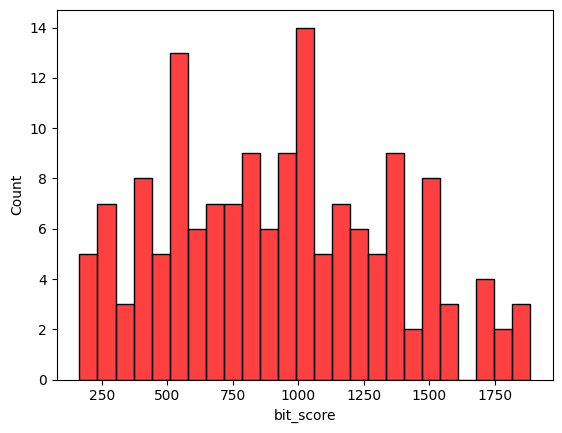

In [59]:
sns.histplot(data = high_id_df, x = 'bit_score', bins = 25, color='r')

In [77]:
r = np.random.randn(100,3)
H, edges = np.histogramdd(r, bins = (5, 8, 4))
H.shape, edges[0].size, edges[1].size, edges[2].size

((5, 8, 4), 6, 9, 5)

In [80]:
edges

[array([-2.65226145, -1.72234986, -0.79243826,  0.13747333,  1.06738493,
         1.99729652]),
 array([-3.86302664, -3.05339209, -2.24375754, -1.43412299, -0.62448844,
         0.18514611,  0.99478066,  1.80441521,  2.61404976]),
 array([-1.96511931, -0.99117055, -0.01722178,  0.95672698,  1.93067574])]

### Number of organisms and pairs represented

In [79]:
for t in ['taxa','taxa_pairs']:
    cmd = f"""SELECT COUNT(*) FROM {t}"""
    print(f'Entries in {t}: {con.execute(cmd).df()}')



Entries in taxa:    count_star()
0         16664
Entries in taxa_pairs:    count_star()
0        750633


In [153]:
def fetch_data_prot(sample_size: int, con: duckdb.DuckDBPyConnection, E_cutoff: float = 100, ID_cutoff: float = 0):
    '''Samples protein_pairs table, then creates a subset of relevant proteins
and joins to output a sample DataFrame. Leaves behind no database objects.
Relatively fast and less memory intensive than creating a new table.'''
    
    st = time.time()
    
    print('Sampling dataset')
    
    validprot_str = f"""CREATE OR REPLACE TABLE validprot AS
        SELECT
            local_gap_compressed_percent_id,
            scaled_local_query_percent_id,
            scaled_local_symmetric_percent_id,
            bit_score,
            query_align_cov,
            subject_align_cov,
            prot_pair_index,
            meso_protein_int_index,
            thermo_protein_int_index
        FROM protein_pairs
        WHERE local_gap_compressed_percent_id >= {ID_cutoff} AND
              local_E_value <= {E_cutoff}
        USING SAMPLE {sample_size}"""
    
    con.execute(validprot_str)
    
    # Extract protein index values from validprot to Python DataFrame, then to list.
    print('Generating index filter')
    get_idx_str = """SELECT meso_protein_int_index, thermo_protein_int_index FROM validprot"""
    protein_index = con.execute(get_idx_str).df()

    meso_protein_list = [i for i in protein_index['meso_protein_int_index']]
    thermo_protein_list = [i for i in protein_index['thermo_protein_int_index']]
    # Generate single string as comma-separated list of protein indices.
    meso_idx_str = ', '.join(map(str, meso_protein_list))
    thermo_idx_str = ', '.join(map(str, thermo_protein_list))
    
    # Create new tables from proteins containing only proteins mentioned in validprot.
    print('Finding relevant proteins')
    relevant_meso_str = f"""CREATE OR REPLACE TABLE relevant_meso AS 
            SELECT * FROM proteins WHERE protein_int_index IN ({meso_idx_str})"""
    relevant_thermo_str = f"""CREATE OR REPLACE TABLE relevant_thermo AS 
            SELECT * FROM proteins WHERE protein_int_index IN ({thermo_idx_str})"""
    con.execute(relevant_meso_str)
    con.execute(relevant_thermo_str)
    
    # Perform final join of sampled dataset to validprot_df, a DataFrame containing all
    # useful features for downstream processing.
    print('Generating final dataset')
    validprot_df_str = """
        SELECT
            validprot.local_gap_compressed_percent_id,
            validprot.scaled_local_query_percent_id,
            validprot.scaled_local_symmetric_percent_id,
            validprot.bit_score,
            validprot.query_align_cov,
            validprot.subject_align_cov,
            proteins_m.protein_seq AS meso_seq,
            proteins_t.protein_seq AS thermo_seq,
            proteins_m.protein_desc AS meso_desc,
            proteins_t.protein_desc AS thermo_desc,
        FROM validprot
        JOIN relevant_meso AS proteins_m ON (validprot.meso_protein_int_index=proteins_m.protein_int_index)
        JOIN relevant_thermo AS proteins_t ON (validprot.thermo_protein_int_index=proteins_t.protein_int_index)
        JOIN taxa
    """
    validprot_df = con.execute(validprot_df_str).df()
    
    # Remove new tabled from database and commit changes so that connection will close properly.
    print('Cleaning up...')
    drop_tables = ['validprot', 'relevant_meso', 'relevant_thermo']
    for table in drop_tables:
        drop_str = f"""DROP TABLE {table}"""
        con.execute(drop_str)
    con.commit()
    print('Done.')
    
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')

    return validprot_df, elapsed_time

In [154]:
test, _ = fetch_data_prot(1,con)
test.head()

Sampling dataset
Generating index filter
Finding relevant proteins
Generating final dataset
Cleaning up...
Done.
Execution time: 0.41454195976257324 seconds


local_gap_compressed_percent_id  scaled_local_query_percent_id  \
0                         0.318841                       0.181818   

   scaled_local_symmetric_percent_id  bit_score  query_align_cov  \
0                           0.193265        243         0.592287   

   subject_align_cov                                           meso_seq  \
0             0.6375  MQPIISISNLSKIYDGGVKALDSVSLEIDKGEIFALLGPNGAGKTT...   

                                          thermo_seq  \
0  MPADDIVLEGVGLKKHFGGGGLLSKPTIVRAVDGVSLAIRRGETFA...   

                             meso_desc  \
0  ABC transporter ATP-binding protein   

                                      thermo_desc  
0  ATP-binding cassette domain-containing protein

In [155]:
con.execute("""SELECT * FROM taxa_pairs LIMIT 1""").df()

thermo_index  meso_index  local_gap_compressed_percent_id  \
0         16320       10668                         0.726236   

   scaled_local_query_percent_id  scaled_local_symmetric_percent_id  \
0                       0.389002                           0.387162   

   local_E_value  query_align_start  query_align_end  subject_align_end  \
0   1.041970e-28                684             1473               1485   

   subject_align_start  query_align_len  query_align_cov  subject_align_len  \
0                  688              790          0.53632                798   

   subject_align_cov  bit_score  taxa_pair_index  is_pair  
0           0.536651       67.0           737280    False

In [156]:
con.execute("""SELECT * FROM taxa LIMIT 1""").df()

taxa_index  ncbi_taxid                                           taxonomy  \
0           0     1968276  Bacteria Bacteroidetes Cytophagia Cytophagales...   

           organism  bacdive_id  \
0  Spirosoma terrae      164169   

                                         seq_16srRNA  len_16s  ogt  
0  ACGATGGAGAGTTTGATCCTGGCTCAGGATGAACGCTAGCGGCAGG...       79  NaN